# Exclusion functions
Simple usage 

In [1]:
!pip install -e ../

Obtaining file:///Users/jsull/Documents/emulator/HZPT%2B/lithe_gzpt/gzpt
  Attempting uninstall: gzpt
    Found existing installation: gzpt 0.3
    Uninstalling gzpt-0.3:
      Successfully uninstalled gzpt-0.3
  Running setup.py develop for gzpt


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from gzpt import hzpt
from gzpt.tracers import AutoCorrelator

klin,plin = np.loadtxt('../../../IRlin/gzpt/tests/test_plin_cc_z0.55.txt',unpack=True) #load some input linear power
model = hzpt(klin,plin) #instantiate the hzpt model (at the plin cosmology)
kk = np.logspace(-3,1,100)
rr = np.logspace(-1,2,100)

## Configuration space

### $F_{\rm{exc}}(r)$

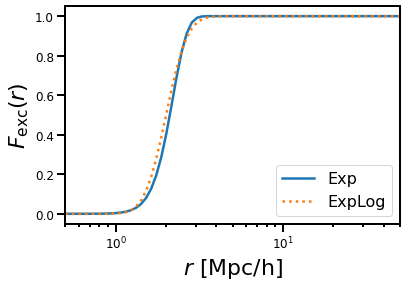

In [2]:
hh = AutoCorrelator([1e-3,2,350,30,5],model,params_exc=[1])
hh0 = AutoCorrelator([1e-3,2,350,30,5],model)

Fr_Exp = hh.Fr_excl(rr,2)
Fr_ExpLog = hh.Fr_excl(rr,2,.1)
plt.plot(rr,Fr_Exp,label='Exp') 
plt.plot(rr,Fr_ExpLog,ls=':',label='ExpLog') 
plt.xlim(.5,50)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$r \ [\rm{Mpc}/h]$')
plt.ylabel(r'$F_{\rm{exc}}(r) $')
plt.show()

### Model with and without exclusion

R,sigma [1] None


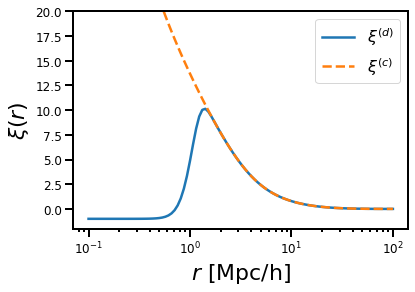

In [3]:
plt.plot(rr,hh.Xi()(rr),label=r'$\xi^{(d)}$')
plt.plot(rr,hh0.Xi()(rr),label=r'$\xi^{(c)}$',ls='--') 
plt.xscale('log')
plt.legend()
plt.xlabel(r'$r \ [\rm{Mpc}/h]$')
plt.ylabel(r'$\xi(r) $')
plt.ylim(-2,20)
plt.show()

## Fourier space

### $F_{\rm{exc}}(k)$

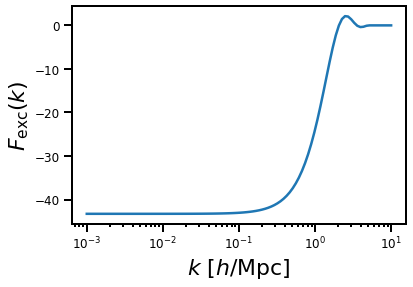

In [4]:
nbar=1e-4
hh = AutoCorrelator([nbar,2,350,30,5],model,params_exc=[2])
hh0 = AutoCorrelator([nbar,2,350,30,5],model)
Fk = hh.Fk_excl(kk,2)
plt.semilogx(kk,Fk) #very similar to k-space top-hat, but slope is slightly different
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$F_{\rm{exc}}(k) $')
plt.show()

### Model with and without exclusion

In [12]:
%%time 
hh = AutoCorrelator([1e-3,2,350,30,5],model,params_exc=[1])

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 13.1 µs


In [13]:
%%time 
_hyp2f_1()

NameError: name '_hyp2f_1' is not defined

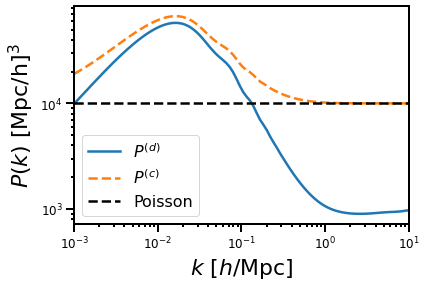

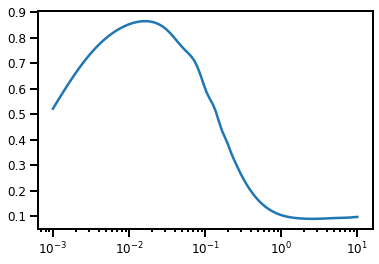

In [14]:
plt.loglog(kk,hh.Power()(kk),label=r'$P^{(d)}$')
plt.loglog(kk,hh0.Power()(kk),ls='--',label=r'$P^{(c)}$')
plt.axhline(1/nbar,ls='--',c='k',label='Poisson')
plt.xlim(1e-3,10)
plt.legend()
plt.xlabel(r'$k \ [h/\rm{Mpc}]$')
plt.ylabel(r'$P(k) \ [\rm{Mpc}/h]^{3}$')
plt.show()
plt.semilogx(kk,hh.Power()(kk) / hh0.Power()(kk))

In [15]:
from scipy.special import poch,gamma
from gzpt.utils import W_TH
#have to do this exercise again
def _hyp0f2(b1,b2, z, eps=1e-6, nmax=10):
    sum = 0
    for k in range(nmax):
        sum+= 1/(poch(b1,k)*poch(b2,k)) * z**k / np.math.factorial(k)
    return sum

def _fk(k,R_excl):
    #see B.8 of paper
    #try to come back and pass arguments for 0F2 convergence
    t1 = R_excl**3 / 3 * gamma(7/4) * _hyp0f2(1/2,5/4,(k*R_excl/4)**4)
    t2 = -k**2 * R_excl**5 /24 * gamma(5/4) * _hyp0f2(3/2,7/4,(k*R_excl/4)**4)
    return 4*np.pi*(t1 + t2)#/(2*np.pi**2)

def F(k,R_excl):
    F = -2*_fk(k,R_excl) + _fk(k,2**(-1/4) * R_excl)
    if(np.any(k>10/R_excl)): F[k>10/R_excl] = 0
    return F


In [16]:
from scipy.interpolate import InterpolatedUnivariateSpline as ius
def convolve(k,x,y):
    #FIXME most naive implementation, could do better with just about anything else for the integral
    #Do the N^2 operation, assume (probably bad) that not zero padding is fine
    #It would be better (for all N>100) to do the fft convolution
    A,B = ius(k,x,ext=1),ius(k,y,ext=1)
    #logdelta = np.log(k[1:]/k[:-1])
    N = len(k)
    res = np.zeros(N)
    for i in range(N):
        res[i] = np.trapz(k**2 * A(abs(k-k[i]))*B(k),x=k)/(2*np.pi**2)
        #res[i] = np.trapz(A(abs(k-k[i]))*B(k),x=k)
    return res

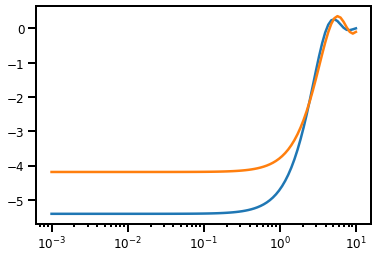

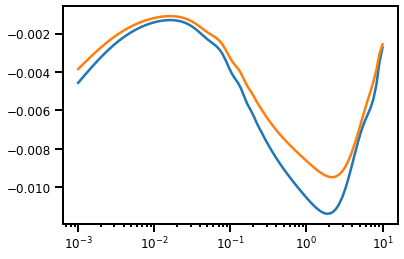

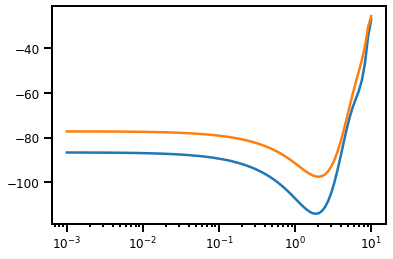

In [17]:
Rtest=1
V = 4/3*np.pi*Rtest**3
plt.semilogx(kk,F(kk,Rtest))
plt.semilogx(kk,-V*W_TH(kk,Rtest))
plt.show()
plt.semilogx(kk,convolve(kk,F(kk,Rtest),hh0.Power()(kk)-1/nbar)/(hh0.Power()(kk)))
plt.semilogx(kk,-V*convolve(kk,W_TH(kk,Rtest),hh0.Power()(kk)-1/nbar)/(hh0.Power()(kk)))
plt.show()
plt.semilogx(kk,convolve(kk,F(kk,Rtest),hh0.Power()(kk)-1/nbar))
plt.semilogx(kk,-V*convolve(kk,W_TH(kk,Rtest),hh0.Power()(kk)-1/nbar) -V*W_TH(kk,Rtest))
# plt.axhline(1/nbar, ls='--',c='k')

In [18]:
from scipy.optimize import curve_fit

4
0.002622713836669922
381.28444896211283


<ipython-input-20-72c08146f795>:36: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-20-72c08146f795>:36: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))


5
0.002622713836669922
1067.1960959799067


<ipython-input-20-72c08146f795>:36: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-20-72c08146f795>:36: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))


6
0.000937034912109375
3365.2039066270936


<ipython-input-20-72c08146f795>:36: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-20-72c08146f795>:36: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))


7
0.00029715881347656254
13084.772699592897


<ipython-input-20-72c08146f795>:36: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-20-72c08146f795>:36: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))


8
7.642471313476563e-05
75785.01368006457


<ipython-input-20-72c08146f795>:36: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-20-72c08146f795>:36: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))


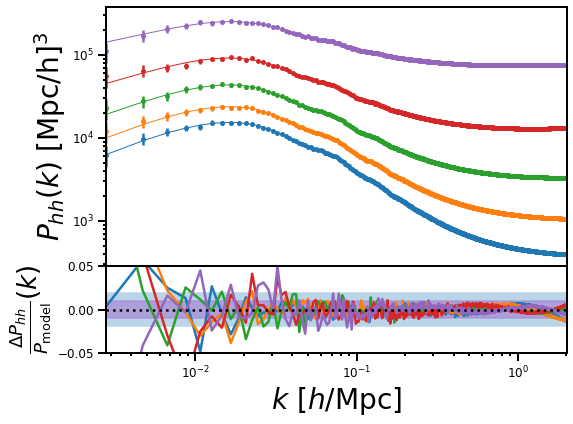

In [20]:
#
def wrap_e1(k,b1,A0,R,R1h,Re):
    #print('nbar',nbar) #hacky
    hhcc = AutoCorrelator(params = [nbar,b1,A0,R,R1h],hzpt=model,params_exc=[Re])
    return hhcc.Power()(k)

def wrap_e2(k,b1,A0,R,R1h,R1sq,R12,Re):
    #print('nbar',nbar) #hacky
    hhcc = AutoCorrelator(params = [nbar,b1,A0,R,R1h,R1sq,R12],hzpt=model,params_exc=[Re])
    return hhcc.Power()(k)

z=0.55
from gzpt.utils import Nk
treebins = np.loadtxt("../../../old_oldGZPT/gzpt/treeBINS.ini")
#hh
hh_k_bin = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/treebins_k-space_z0.55_hh_params')

nbins = np.arange(0,9)
fig = plt.figure(figsize=(8,6),facecolor='white')
ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])#, #left bottom width height
                  # xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2],
                   ylim=(-.05,.05))

fit_pars=[]
for i,b in enumerate(nbins):
    #if(i <3):
    if(i >=4):
        print(i)
        print(nbar)
        #hhcc = AutoCorrelator(params = list(hh_k_bin[i]),hzpt=model,params_exc=[1])
        kf,Pkhh,Pkhm = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/cc_z0.55_bin{0}_halo_only_stats_big.txt'.format(b),unpack=True)
        sn = Pkhh[0]
        k_sim,Phh_sim = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/hh_z0.55_bin{0}_fid.txt'.format(b),unpack=True)
        print(sn)
        sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
        nbar= 1/sn
        k_index = np.where((k_sim>0))# & (k_sim<1.1))
        k_cut, P_cuthh = k_sim[k_index],Phh_sim[k_index]
        
        popt,_ = curve_fit(wrap_e1,k_cut,P_cuthh,p0=list(hh_k_bin[i][1:])+[1],
                          bounds=(0,np.inf))#,sigma=sigPhh[k_index])
        popt,_ = curve_fit(wrap_e2,k_cut,P_cuthh,p0=list(hh_k_bin[i][1:])+[25,2,1],
                          bounds=([0,0,0,0,-100,1,0],np.inf))#,sigma=sigPhh[k_index])
        fit_pars.append(popt)
#         popt=fit_pars[i-4]
        if(i==1):
            p1 = ax1.plot(k_cut,wrap_e2(k_cut,*popt),lw=1)

#             p1 = ax1.plot(k_cut,wrap_e1(k_cut,*popt),lw=1)
        else:
            p1 = ax1.plot(k_cut,wrap_e2(k_cut,*popt),lw=1)

#             p1 = ax1.plot(k_cut,wrap_e1(k_cut,*popt),lw=1)

        ax1.errorbar(k_cut,P_cuthh,sigPhh[k_index],ls=' ',marker='.',label='bin {0}'.format(i),c=p1[0].get_color())

#         ax2.plot(k_cut,P_cuthh/wrap_e1(k_cut,*popt) -1,label='z{0}'.format(z),c=p1[0].get_color()) 
        ax2.plot(k_cut,P_cuthh/wrap_e2(k_cut,*popt) -1,label='z{0}'.format(z),c=p1[0].get_color()) 


ax2.set_xlabel(r'$k \ [h/\rm{Mpc}]$',fontsize=28)
ax1.set_ylabel(r'$P_{hh} (k)\ [\rm{Mpc}/h]^{3}$',fontsize=28)
ax2.set_ylabel(r'$\frac{\Delta P_{hh}}{P_{\rm{model}}} (k) $',fontsize=26)

ax2.fill_between(k_sim,-0.01,0.01,alpha=0.3,color='m')
ax2.fill_between(k_sim,-0.02,0.02,alpha=0.3)
ax2.axhline(0,c='k',ls=':')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax1.set_xlim(min(k_cut),max(k_cut))
ax2.set_xlim(min(k_cut),max(k_cut))
#ax1.legend(prop={'size': 12})
#plt.tight_layout()
plt.savefig('./fc_fcc_nm2e_pk_thin_hh_fit_cc_bin.png',facecolor=fig.get_facecolor(), edgecolor='none')#.eps',dpi=600)
plt.show()


In [40]:
fit_pars

[array([1.02504572e+00, 1.23827502e+03, 1.35385109e+01, 1.36141068e+01,
        1.77522752e+01, 2.22806559e+00, 3.35719536e-01]),
 array([1.26212793e+00, 1.24402781e+03, 1.38899493e+01, 1.40320994e+01,
        2.93389076e+01, 1.90634292e+00, 7.00074637e-01]),
 array([  1.68247547, 946.0869901 ,   9.73010028,   9.88469796,
         18.5510534 ,   1.54323185,   1.06467664]),
 array([ 2.32635608e+00,  1.62866573e+04,  3.11963514e+00,  5.24335411e+01,
        -1.00000000e+02,  1.06482069e+01,  1.11639619e+00]),
 array([  3.4635416 , 852.64722273, 109.65604337,   5.97905156,
         -1.1633252 ,  18.68953888,   2.41496803])]

In [44]:
#accumulate residuals
resids = []
for i in range(5):
        kf,Pkhh,Pkhm = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/cc_z0.55_bin{0}_halo_only_stats_big.txt'.format(i+4),unpack=True)
        sn = Pkhh[0]
        nbar= 1/sn
        k_sim,Phh_sim = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/hh_z0.55_bin{0}_fid.txt'.format(i+4),unpack=True)
        k_index = np.where((k_sim>0))# & (k_sim<1.1))
        k_cut, P_cuthh = k_sim[k_index],Phh_sim[k_index]
        resids.append(P_cuthh/wrap_e2(k_cut,*fit_pars[i]) -1)
#save
np.savetxt('residual_full_exclusion_hh_thin_bins.dat',np.transpose([k_cut,*resids]))

In [47]:
!pwd

/Users/jsull/Documents/emulator/HZPT+/lithe_gzpt/gzpt/examples


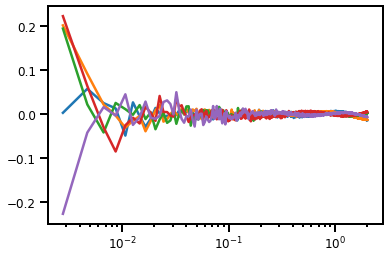

In [46]:
for i in range(1,6):
    plt.semilogx(np.loadtxt('residual_full_exclusion_hh_thin_bins.dat')[:,0],
                 np.loadtxt('residual_full_exclusion_hh_thin_bins.dat')[:,i])

In [ ]:
#This generally takes forever because of my lazy convolution implementation I am guessing - it would be better to use FFTLog in \xi,
#but the point here was to show the Fourier space model works! And it does
#I need to do a more detailed check on the convolution timing, here it is actually not impossibly slow, but 
#for gg it just times out basically - somewhere else I found that it took 7 seconds (!) to evaluate Phh once...

In [25]:
len(k_cut)

1023

In [29]:
fit_pars #no errors, no bounds, and free sn end up with negative exclusion radii = bad. things look better for large mass

[array([ 2.47267566e-03,  1.03280655e+00,  8.83467713e+02,  4.37498930e+01,
         7.32146692e+00, -5.24863947e-01]),
 array([ 9.28551462e-04,  1.27577222e+00,  8.54079438e+02,  3.71280069e+01,
         6.54339353e+00, -1.01807047e+00]),
 array([ 3.04276271e-04,  1.70497484e+00,  6.38573323e+02, -3.31187870e+01,
         5.11574104e+00, -3.95116336e-01]),
 array([ 7.64288554e-05,  2.38054574e+00,  7.63251918e+02, -4.78126803e+01,
         5.71777103e+00,  1.47015377e+00]),
 array([1.31071815e-05, 3.46338322e+00, 1.57606199e+03, 1.08497701e+02,
        7.65364651e+00, 2.11923367e+00])]

In [34]:
fit_pars #this is with bounds and errors and free sn - large scales are very wrong - spends all effort on small scales

[array([1.13849990e+00, 9.26364005e+01, 6.20554030e+03, 1.00743211e+00,
        8.94541691e-01]),
 array([  1.38359705, 167.02237696, 109.6716521 ,   1.59151074,
          1.10920927]),
 array([  1.90674772, 443.1429711 ,   3.39133298,   3.39646873,
          1.33513902]),
 array([  2.52183235, 298.93690441,  38.08753688,   1.90169924,
          1.86564425]),
 array([ 4.03328767, 82.71067119, 32.39819264,  0.52441333,  2.0346157 ])]

In [37]:
fit_pars #with bounds, no errors
#This is WITHOUT free sn - still do a pretty good job for bins 6,7,8

[array([1.03415112e+00, 7.95027619e+02, 4.83181179e+01, 6.07925754e+00,
        5.81130104e-05]),
 array([1.27622212e+00, 8.27914252e+02, 3.81343263e+01, 6.20665189e+00,
        5.57186101e-06]),
 array([  1.70509549, 639.22625809,  33.13245727,   5.06169546,
          1.06123488]),
 array([  2.38061408, 762.3207007 ,  47.82242366,   5.70888067,
          1.4718061 ]),
 array([   3.42776237, 1857.42215944,  115.14969482,    9.10242547,
           1.86238436])]

In [42]:
#same as above but with nmax=2 to try to get the smaller mass bins
fit_pars
#and it does! exclusion radii actually look pretty sensible as well

#I bet the alpha model would do fine here, but wouldnt work in configuration space

[array([1.03468630e+00, 1.44219013e+03, 2.79554037e+01, 1.36993354e+01,
        2.27892621e+01, 1.88734825e+00, 5.21721989e-07]),
 array([1.27567956e+00, 2.48126158e+03, 1.94604664e+01, 1.96236242e+01,
        4.25540634e+01, 1.95377489e+00, 7.40687548e-01]),
 array([1.70652999e+00, 1.75503108e+03, 1.71369247e+01, 1.70872896e+01,
        5.12902525e+01, 1.79135511e+00, 1.25107320e+00]),
 array([2.37293049e+00, 2.32664321e+03, 2.82834307e+01, 2.82927006e+01,
        1.73974925e+02, 1.94070607e+00, 1.58244894e+00]),
 array([3.05416252e+00, 7.69305341e+03, 1.55918421e+02, 2.02246653e+01,
        7.09246810e+01, 2.65390638e+00, 2.75430042e+00])]

In [78]:
#was using wrong linear power spectrum, now using the right one (cc is not planck, neutrinos...)
fit_pars
#no drastic changes

[array([1.02501401e+00, 1.23557973e+03, 1.35649613e+01, 1.36369414e+01,
        1.79540017e+01, 2.21135838e+00, 3.25176684e-01]),
 array([1.26193994e+00, 1.21981738e+03, 1.41149742e+01, 1.42587107e+01,
        3.29773031e+01, 1.83109007e+00, 7.02707901e-01]),
 array([  1.68292424, 750.41769724,  11.19713639,   9.33443548,
         26.59977489,   1.3864472 ,   1.18277944]),
 array([  2.35697197, 342.60049583,  35.82024421,   7.60018642,
         65.73261057,   1.        ,   1.5150333 ]),
 array([3.02319331e+00, 7.81134145e+03, 1.57305484e+02, 2.29895709e+01,
        9.25565340e+01, 2.81586871e+00, 2.75292630e+00])]

In [21]:
#same as above but fixed convolution k2normalization
fit_pars
#it is actually not that different, 

[array([1.02504572e+00, 1.23827502e+03, 1.35385109e+01, 1.36141068e+01,
        1.77522752e+01, 2.22806559e+00, 3.35719536e-01]),
 array([1.26212793e+00, 1.24402781e+03, 1.38899493e+01, 1.40320994e+01,
        2.93389076e+01, 1.90634292e+00, 7.00074637e-01]),
 array([  1.68247547, 946.0869901 ,   9.73010028,   9.88469796,
         18.5510534 ,   1.54323185,   1.06467664]),
 array([ 2.32635608e+00,  1.62866573e+04,  3.11963514e+00,  5.24335411e+01,
        -1.00000000e+02,  1.06482069e+01,  1.11639619e+00]),
 array([  3.4635416 , 852.64722273, 109.65604337,   5.97905156,
         -1.1633252 ,  18.68953888,   2.41496803])]

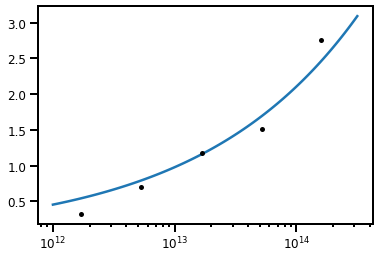

In [79]:
from gzpt.utils import rDelta
mm = np.logspace(12,14.5,100)
Re_fits = [f[-1] for f in fit_pars]
mean_bins = np.array([12.22929457, 12.727012,13.22259507 ,13.71412233, 14.19807821])
plt.plot(mm,rDelta(mm,0.55,mdef='Lag')/2)
#plt.semilogx(mm,(mm/1e14)**nu,ls=':')
plt.plot(10**mean_bins,Re_fits,ls=' ',marker='.',c='k')
plt.xscale('log')
# plt.yscale('log')

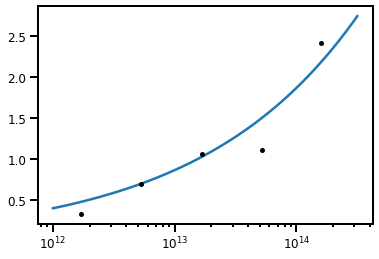

In [24]:
from gzpt.utils import rDelta
mm = np.logspace(12,14.5,100)
Re_fits = [f[-1] for f in fit_pars]
mean_bins = np.array([12.22929457, 12.727012,13.22259507 ,13.71412233, 14.19807821])
plt.plot(mm,rDelta(mm,0.55,mdef='Lag')/2.25)
#plt.semilogx(mm,(mm/1e14)**nu,ls=':')
plt.plot(10**mean_bins,Re_fits,ls=' ',marker='.',c='k')
plt.xscale('log')
# plt.yscale('log')

In [ ]:
#thick bins

1
0.0012341937255859374
810.2455710713054


<ipython-input-50-6bd07a68a8e5>:19: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-50-6bd07a68a8e5>:19: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))


2
0.0012341937255859374
11158.231817986793


<ipython-input-50-6bd07a68a8e5>:19: RuntimeWarning: divide by zero encountered in true_divide
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-50-6bd07a68a8e5>:19: RuntimeWarning: invalid value encountered in multiply
  sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
<ipython-input-50-6bd07a68a8e5>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


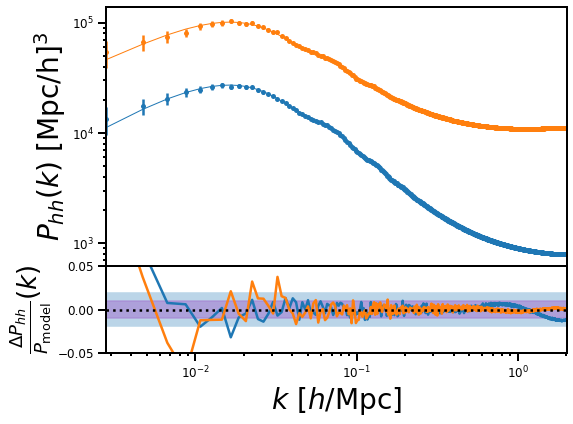

In [50]:

nbins = np.arange(0,9)
fig = plt.figure(figsize=(8,6),facecolor='white')
ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])#, #left bottom width height
                  # xticklabels=[], ylim=(-1.2, 1.2))
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2],
                   ylim=(-.05,.05))

fit_pars=[]
for i,b in enumerate(nbins):
    if((i>0) and (i <3)):
#     if(i >=4):
        print(i)
        print(nbar)
        #hhcc = AutoCorrelator(params = list(hh_k_bin[i]),hzpt=model,params_exc=[1])
        kf,Pkhh,Pkhm = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/cc_z0.55_bin{0}_halo_only_stats_big.txt'.format(b),unpack=True)
        sn = Pkhh[0]
        k_sim,Phh_sim = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/hh_z0.55_bin{0}_fid.txt'.format(b),unpack=True)
        print(sn)
        sigPhh = np.sqrt(2/Nk(k_sim,L=3200))*(Phh_sim)#-sn)*(1 + 1/((Phh_sim-sn)/sn))
        nbar= 1/sn
        k_index = np.where((k_sim>0))# & (k_sim<1.1))
        k_cut, P_cuthh = k_sim[k_index],Phh_sim[k_index]
        
        popt,_ = curve_fit(wrap_e1,k_cut,P_cuthh,p0=list(hh_k_bin[i][1:])+[1],
                          bounds=(0,np.inf))#,sigma=sigPhh[k_index])
        popt,_ = curve_fit(wrap_e2,k_cut,P_cuthh,p0=list(hh_k_bin[i][1:])+[25,2,1],
                          bounds=([0,0,0,0,-100,1,0],np.inf))#,sigma=sigPhh[k_index])
        fit_pars.append(popt)
#         popt=fit_pars[i-4]
        if(i==1):
            p1 = ax1.plot(k_cut,wrap_e2(k_cut,*popt),lw=1)

#             p1 = ax1.plot(k_cut,wrap_e1(k_cut,*popt),lw=1)
        else:
            p1 = ax1.plot(k_cut,wrap_e2(k_cut,*popt),lw=1)

#             p1 = ax1.plot(k_cut,wrap_e1(k_cut,*popt),lw=1)

        ax1.errorbar(k_cut,P_cuthh,sigPhh[k_index],ls=' ',marker='.',label='bin {0}'.format(i),c=p1[0].get_color())

#         ax2.plot(k_cut,P_cuthh/wrap_e1(k_cut,*popt) -1,label='z{0}'.format(z),c=p1[0].get_color()) 
        ax2.plot(k_cut,P_cuthh/wrap_e2(k_cut,*popt) -1,label='z{0}'.format(z),c=p1[0].get_color()) 


ax2.set_xlabel(r'$k \ [h/\rm{Mpc}]$',fontsize=28)
ax1.set_ylabel(r'$P_{hh} (k)\ [\rm{Mpc}/h]^{3}$',fontsize=28)
ax2.set_ylabel(r'$\frac{\Delta P_{hh}}{P_{\rm{model}}} (k) $',fontsize=26)

ax2.fill_between(k_sim,-0.01,0.01,alpha=0.3,color='m')
ax2.fill_between(k_sim,-0.02,0.02,alpha=0.3)
ax2.axhline(0,c='k',ls=':')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax1.set_xlim(min(k_cut),max(k_cut))
ax2.set_xlim(min(k_cut),max(k_cut))
#ax1.legend(prop={'size': 12})
plt.tight_layout()
plt.savefig('./fc_fcc_nm2e_pk_thick_hh_fit_cc_bin.png',facecolor=fig.get_facecolor(), edgecolor='none')#.eps',dpi=600)
plt.show()


In [51]:
fit_pars

[array([1.36321398e+00, 1.09324751e+03, 1.26508588e+01, 1.28016231e+01,
        2.64762460e+01, 1.81528638e+00, 8.32782043e-01]),
 array([  2.51141485, 378.76282393,  55.69044861,   3.37891017,
         -1.9824094 ,   1.31489747,   1.90688165])]

In [52]:
#accumulate residuals
resids = []
for i in range(2):
        kf,Pkhh,Pkhm = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/cc_z0.55_bin{0}_halo_only_stats_big.txt'.format(i+1),unpack=True)
        sn = Pkhh[0]
        nbar= 1/sn
        k_sim,Phh_sim = np.loadtxt('../../../old_oldGZPT/gzpt/sims/cc/new-binM/hh_z0.55_bin{0}_fid.txt'.format(i+1),unpack=True)
        k_index = np.where((k_sim>0))# & (k_sim<1.1))
        k_cut, P_cuthh = k_sim[k_index],Phh_sim[k_index]
        resids.append(P_cuthh/wrap_e2(k_cut,*fit_pars[i]) -1)
#save`
np.savetxt('residual_full_exclusion_hh_thick_bins.dat',np.transpose([k_cut,*resids]))

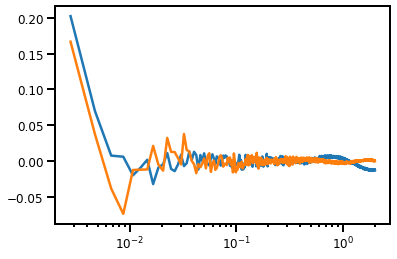

In [53]:
for i in range(1,3):
    plt.semilogx(np.loadtxt('residual_full_exclusion_hh_thick_bins.dat')[:,0],
                 np.loadtxt('residual_full_exclusion_hh_thick_bins.dat')[:,i])